## PHYS-F-302 : Mécanique Quantique, partie numérique

Aurélien Manera

 Le problème consiste à résoudre l'équation $\Delta^2\psi=0$ par la méthode du gradient conjugué.

Nous allons décrire le flux de Stokes dans une cavitée carrée en résolvant une équation biharmonique. Le flux de Stokes nous permet de simplifier les équations de Navier-Stokes, en éliminant la non-linéarité. 

Il faut tout d'abord discétiser une équation biharmonique :

\begin{equation}
\nabla^{4}\psi = 0
\end{equation}


On a donc :

\begin{equation}
\nabla^{2}(\nabla^{2}\psi) = 0
\end{equation}

\begin{equation}
\partial_{x}^{4}\psi + \partial_{y}^{4}\psi + 2\partial_{x}^{2}\partial_{y}^{2}\psi = 0 
\end{equation}

Maintenant, nous allons la discrétiser :
    
\begin{equation}
\partial_{x}^{4}\psi \approx \dfrac{\psi[i-2,j]-4\psi[i-1,j] + 6\psi[i,j]-4\psi[i+1,j]+ \psi[i+2,j]}{dx^{4}}
\end{equation}

\begin{equation}
\partial_{y}^{4}\psi \approx \dfrac{\psi[i,j-2]-4\psi[i,j-1] + 6\psi[i,j]-4\psi[i,j+1]+ \psi[i,j+2]}{dy^{4}}
\end{equation}

\begin{equation}
\partial_{x}^{2}\partial_{y}^{2}\psi \approx \dfrac{\psi[i-1,j+1]-2\psi[i,j+1] + \psi[i+1,j+1]-2\psi[i-1,j]+ 4\psi[i,j]-2\psi[i+1,j]+\psi[i-1,j-1]-2\psi[i,j-1]+\psi[i+1,j-1]}{dx^{2}dy^{2}} 
\end{equation}

\begin{align*}
0 = \nabla^{4}\psi 
& \approx \dfrac{\psi[i-2,j]-4\psi[i-1,j] + 6\psi[i,j]-4\psi[i+1,j]+ \psi[i+2,j]}{dx^{4}} \\
& + \dfrac{\psi[i,j-2]-4\psi[i,j-1] + 6\psi[i,j]-4\psi[i,j+1]+ \psi[i,j+2]}{dy^{4}} \\
& + 2\dfrac{\psi[i-1,j+1]-2\psi[i,j+1] + \psi[i+1,j+1]-2\psi[i-1,j]+ 4\psi[i,j]-2\psi[i+1,j]+\psi[i-1,j-1]-2\psi[i,j-1]+\psi[i+1,j-1]}{dx^{2}dy^{2}}
\end{align*}


Où nous avons utilisé le lien suivant pour trouver les coefficients :
https://en.wikipedia.org/wiki/Finite_difference_coefficient

## Justication des conditions aux bords 


Initialement, on considère un écoulement  instable dans le temps d'un fluide visqueux et incompressible dans une cavité carrée. L'écoulement est engendré par la viscosité dû au mouvement de la paroi supérieure qui est animée d'une vitesse de translation uniforme. Les autres parois étant immobiles. La justification des conditions aux bords se caractérise par le non glissement des particules du fluide sur les parois solides et l'imperméabilité de celle-ci, ce que donne $u=v=0$ sur toutes les parois. 
En réalité, cela implique que la vitesse tangentielle du fluide au plus proche des bords est la même que la vitesse de la paroi. Par exemple, la vitesse tangentielle près du bord mobile de vitesse $1$ sera $u=1$. 

Nous importons ce dont nous avons besoin pour résoudre notre problème.

## Implémentation du code 

In [176]:
import matplotlib.pyplot as plt
import numpy
import scipy.sparse as sp
import scipy.sparse.linalg
from math import pi, cos, sin
%matplotlib inline
from matplotlib import rcParams 
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

On va également utiliser les paramètres de discrétisation imposé dans le MOOC.

Pour implémenter nos conditions aux bords, nous allons d'abord les discrétiser à l'aide du lien wikipédia.

On a donc que :

\begin{equation}
\partial_{x} \psi = \dfrac{\dfrac{-3}{2}\psi[i,j] + 2\psi[i+1,j] - \dfrac{1}{2} \psi[i+2,j]}{dx}
\end{equation}

\begin{equation}
\partial_{y} \psi = \dfrac{\dfrac{-3}{2}\psi[i,j] + 2\psi[i,j+1] -\dfrac{1}{2} \psi[i,j+2]}{dy}
\end{equation}
Au bord: 
\begin{equation}
\psi = 0 
\end{equation}

Dès lors, on peut implémenter nos conditions aux bords comme suit : à la $t$-ième itération on force que

\begin{cases}
-\dfrac{3}{2}p_t[0,:] &+& 2p_t[1,:] &-& \dfrac{1}{2}p_t[2,:] &=& 0 & \text{(Bord $x=0$)} \\
-\dfrac{3}{2}p_t[-3,:] &+& 2p_t[-2,:] &-& \dfrac{1}{2}p_t[-1,:] &=& 0 & \text{(Bord $x=1$)} \\
-\dfrac{3}{2}p_t[:,0] &+& 2p_t[:,1] &-& \dfrac{1}{2}p_t[:,2] &=& 0 & \text{(Bord $y=0$)} \\
-\dfrac{3}{2}p_t[:,-3] &+& 2p_t[:,-2] &-& \dfrac{1}{2}p_t[:,-1] &=& dy & \text{(Bord $y=1$)}
\end{cases}

On peut ainsi implémenter les conditions aux bords et le bilaplacien 

In [177]:
def ensure_bc(p,dy):
    
    p_bc = p.copy()
    
    p_bc[0,:] = 0
    p_bc[-1,:] = 0
    p_bc[:,0] = 0
    p_bc[:,-1] = 0

    p_bc[1,:]  = (1/4)*p[2,:] #forward
    p_bc[-2,:] = (1/4)*p[-3,:] #backward
    p_bc[:,1]  = (1/4)*p[:,2] #forward
    p_bc[:,-2] = (1/4)*p[:,-3] - dy/2 #backward
    return(p_bc)

In [178]:
def bilap(p_brut, dy) : # bilaplacien après s'être des conditions au bord
    N = p_brut.shape[0]
    p = ensure_bc(p_brut,dy)
    Ad = numpy.zeros((N,N))
    Ad[2:-2,2:-2] =                        1*p[2:-2,:-4]\
                        + 2*p[1:-3,1:-3] - 8*p[2:-2,1:-3]  + 2*p[3:-1,1:-3]\
        + 1*p[:-4,2:-2] - 8*p[1:-3,2:-2] + 20*p[2:-2,2:-2] - 8*p[3:-1,2:-2] + 1*p[4:,2:-2]\
                        + 2*p[1:-3,3:-1] - 8*p[2:-2,3:-1]  + 2*p[3:-1,3:-1]\
                                         + 1*p[2:-2,4:]
    Ad = Ad/dy**4
    return Ad

On doit utiliser la méthode du gradient conjugué qui est donnée explicitement dans le mooc, pour résoudre l'équation.

In [179]:
def L1norm(matrix,dx): # Si tu retires les erreurs relatives, tu peux bazarder
    ''' Compute the L1 norm c
     Parameters: 
     ---------- 
     matrix: array of float 
         array 1  
    ------- 
     Relative L1 norm of the difference '''
    norm = numpy.sum(numpy.abs(matrix)) * dx**2
    
    return norm

In [180]:
def L1_diff(new,old,dx):
    ''' Compute the relative L1 norm of the difference of functions on unit square given on a mesh of size dx
     Parameters: 
     ---------- 
     new : array of float 
         array 1 
     old : array of float 
         array 2 
     Returns: 
    ------- 
     Relative L1 norm of the difference '''
    norm = numpy.sum(numpy.abs(new-old)) * dx**2
    return norm

In [192]:
def conjugate_gradient_2d(p, b, dx, dy, l1_target):
    '''Performs cg relaxation
    Assumes Dirichlet boundary conditions p=0
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    b : 2D array of floats
        Source term
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l2_target: float
        exit criterion
        
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''
    ny, nx = p.shape
    r  = numpy.zeros((ny,nx)) # residual
    Ad  = numpy.zeros((ny,nx)) # to store result of matrix multiplication 
    
    l1_norm = 1
    iterations = 0
    #l1_conv = []
    
    # Step-0 We compute the initial residual and 
    # the first search direction is just this residual
    r = b - bilap(p,dx) # Ici 
    d = r.copy()
    rho = numpy.sum(r*r)
    Ad = bilap(d,dx) # La
    sigma = numpy.sum(d*Ad)
    
    # Iterations
    while l1_norm > l1_target:

        pk = p.copy()
        rk = r.copy()
        dk = d.copy()
        
        alpha = rho/sigma

        p = pk + alpha*dk
        r = rk - alpha*Ad
        
        rhop1 = numpy.sum(r*r)
        beta = rhop1 / rho
        rho = rhop1
        
        d = r + beta*dk
        Ad = bilap(d,dx)
        sigma = numpy.sum(d*Ad)
        
        # BCs are automatically enforced
        
        l1_norm = L1_diff(pk,p,dx)
        iterations += 1
        #l1_conv.append(l1_norm) # Vérifier si dans le MOOC, sinon retirer ici et
    
    print('Number of CG iterations: {0:d}'.format(iterations))
    return p   

In [193]:
nx = 41
ny = 41

l = 1.
h = 1.

dx = l/(nx-1)
dy = h/(ny-1)

l1_target = 1e-8

x  = numpy.linspace(0,l,nx)
y  = numpy.linspace(0,h,ny)

b = numpy.zeros((nx,ny)) 
b = ensure_bc(b,dy) 

p_init = numpy.zeros((nx,ny)) # initial guess

In [194]:
p = conjugate_gradient_2d(p_init, b, dx, dy, l1_target) 

Number of CG iterations: 768


In [184]:
print(p)

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
   -1.92830362e-05   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
   -1.92830362e-05   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00  -6.45514214e-06 ...,  -1.41060915e-02
   -1.92830362e-05   0.00000000e+00]
 ..., 
 [  0.00000000e+00   0.00000000e+00  -6.45515176e-06 ...,  -1.41060915e-02
   -1.92830362e-05   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
   -1.92830362e-05   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
   -1.92830362e-05   0.00000000e+00]]


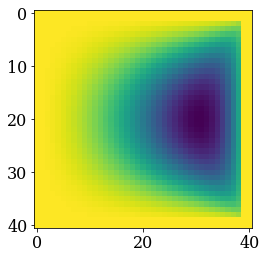

In [185]:
plt.imshow(p)

In [186]:
rel_err = L1norm(bilap(p,dx),dx) / L1norm(p,dx)

In [187]:
rel_err

5.296483227410107

Ceci nous montre que le liquide va créer du remous à faible profondeur, alors qu'il reste "calme" sur les trois autres côtés de la boite. Ce schéma semble ressembler à celui suggéré comme solution finale dans l'énoncé du problème. On peut apercevoir que les conditions aux bords sur $\psi$ semblent bien respectées: $\psi = 0$ le long des bords et les dérivées selon $x$ et selon $y$ s'annulent aux bords. On peut noter que sur le bord supérieure, là où la couleur est foncée, la dérivée ne s'annule pas.   

Quelle est la valeur de la fonction de flux $\psi$ en (0.6;0.6)?

In [188]:
p[24,24]

-0.073807772553525761

Quelle est la valeur de la fonction de flux $\psi$ en (0.6;0.2)?

In [189]:
p[24,8]

-0.010044562002181772

Quelle est la valeur de la fonction de flux $\psi$ en (0.6;0.4)?

In [190]:
p[24,16]

-0.036165903145769479

Quelle est la valeur de la fonction de flux $\psi$ en (0.6;0.8)?

In [191]:
p[24,32]

-0.094467595421445769

## CONCLUSION
  

L'énoncé du problème était de résoudre un bilaplacien $\psi$ pour trouver la valeur de la fonction de flux $\psi$ à certains endroits. La discrétisation du bilaplcien d'ordre 2 était nécessaire ainsi que la discrétisation des conditions aux bords. Ainsi vient l'implémentation de la méthode demandée (méthode du gradient conjugué) en modifiant l'algorithme pour l'adapter à notre problème. La solution de notre problème semble correcte, en raison de la solution trouvée. 